# Compute the sWeights 
For a given cut on the `BDT` value, with the starting value of the fit chosen as the result of the previous fit, specified by `cut_BDT_ref`, manually chosen to be `cut_BDT - 0.05`.
1. Fit on $m(3\pi)$ for $|m(3\pi) - 1968|<50$
    - Signal shape: Gaussian
    - Background shape: Exponential
2. Compute the associated probability and sWeights, save the sWeights in a Pickle file.
3. Plot some interesting things for checking
4. Save the full dataframe in a root file. It will be the input of `fit_all_data_V8_2_files_BDTs_recomputed_sWeights.ipynb`.

The saved root file is already cut on the `BDT` output, and has a new column `sWeight`.

In [1]:
import zfit
import json
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from hep_ml import splot
import timeit
from scipy.stats import pearsonr

from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)
from load_save_data import load_data, save_dataframe
from plot.tool import fix_plot
import plot.histogram as h
from plot.fit import plot_hist_fit_particle
from fit import launch_fit, define_zparams, save_params, format_previous_params

/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Welcome to JupyROOT 6.22/02


## Retrieve data

In [2]:
# load_data does the cut on DeltaM and tau_M (around m(Ds)).
df_common_Ds = load_data(years, magnets, type_data='common', vars=['B0_M', 'tau_M', 'BDT'],
                            cut_DeltaM=True, cut_tau_Ds=True)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/common/common_B0toDstDs.root


In [3]:
name_data = 'all_common_cutDeltaM_Ds23pi_V8'

## Cut on BDT

In [113]:
cut_BDT = -0.26
k = str(cut_BDT)

In [114]:
df_Ds = df_common_Ds.query(f"BDT > {cut_BDT}")

Reference fit whose results are taken as the starting values of the new fit.
It is specified by `cut_BDT_ref`, the cut on the `BDT` output.
If None, the reference fit is the one performed without any cut on the `BDT` output.

In [115]:
cut_BDT_ref = None

In [116]:
if cut_BDT_ref is None:
    with open(f'{loc.JSON}/{name_data}_params.json', 'r') as f:
        params_r = json.load(f)
    
else:
    with open(f'{loc.JSON}/{name_data}_BDT{cut_BDT_ref}_params.json', 'r') as f:
        params_recup = json.load(f)

    params_r = format_previous_params(params_recup)

In [117]:
size_tau_M = 50.
mean_tau_M = 1969.
low_tau_M = mean_tau_M - size_tau_M
high_tau_M = mean_tau_M + size_tau_M

## Histogram

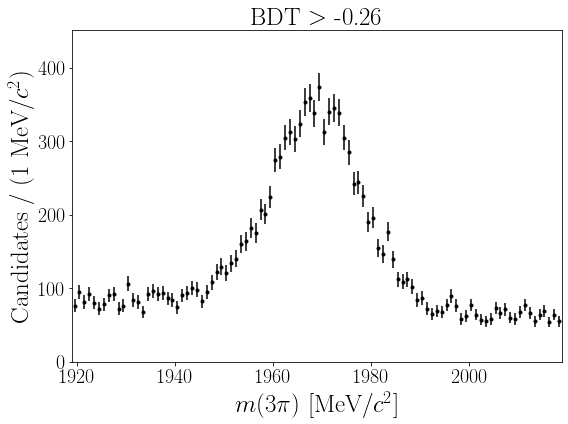

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/tau_M_all_common_cutDeltaM_Ds23pi_V8_BDT-0.26.pdf


In [118]:
h.plot_hist_particle({name_data:df_Ds},'tau_M', cut_BDT=cut_BDT,
              n_bins = 100, mode_hist = False, colors='black')

## Fit on $m(3\pi)$ = gaussian (signal) + exponential (background)

### Initial conditions

In [119]:
n_events_tau_M = len(df_Ds)
initial_values_tau = {
    'mu_tau': {
        'value' : params_r['mu_tau'],
        'low': 1965.,
        'high': 1975.,     
    },
    'sigma_tau': {
        'value' : params_r['sigma_tau'],
        'low': 5.,
        'high': 15.,
    },
    'n_bkg_tau': {
        'value' : params_r['n_bkg_tau'],
        'low': 0,
        'high': n_events_tau_M,  
    },
    'n_sig_tau': {
        'value' : params_r['n_sig_tau'],
        'low': 0,
        'high': n_events_tau_M,  
    },
    'lambda_tau': {
        'value' : params_r['lambda_tau'],
        'low': -0.01,
        'high': -0.000001  
    }
}

### Parameters and pdf

In [120]:
obs_tau = zfit.Space("x", limits=(low_tau_M, high_tau_M))
zparams_tau = define_zparams(initial_values_tau, cut_BDT=cut_BDT)

In [121]:
name_params_tau = {
    # Signal
    f'mu_tau|BDT{cut_BDT}'     :'$\mu_{S}$',
    f'sigma_tau|BDT{cut_BDT}'  :'$\sigma_{S}$',
    f'n_sig_tau|BDT{cut_BDT}'  :'$n_{S}$',
    # Combinatorial background
    f'n_bkg_tau|BDT{cut_BDT}'  :'$n_{B,c}$',
    f'lambda_tau|BDT{cut_BDT}' :'$\\lambda_{B,c}$',
}

In [122]:
gaussian_tau = zfit.pdf.Gauss(zparams_tau["mu_tau"],zparams_tau["sigma_tau"],obs=obs_tau)
exponential_tau = zfit.pdf.Exponential(zparams_tau["lambda_tau"], obs=obs_tau)

gaussian_ext_tau = gaussian_tau.create_extended(zparams_tau["n_sig_tau"])
exp_ext_tau = exponential_tau.create_extended(zparams_tau["n_bkg_tau"])
model_tau = zfit.pdf.SumPDF([gaussian_ext_tau, exp_ext_tau]) # gauss is folded by frac

data_tau = zfit.Data.from_pandas(df_Ds['tau_M'],obs=obs_tau)

### Launch fit

In [123]:
start = timeit.default_timer()
result_tau, params_tau = launch_fit(model_tau, data_tau, extended=True)
result_tau, params_tau = launch_fit(model_tau, data_tau, extended=True)
stop = timeit.default_timer()
print('Time to do the fit: ', stop - start) 


------------------------------------------------------------------
| FCN = -5.68e+04               |     Ncalls=129 (129 total)     |
| EDM = 5.59e-05 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name                     value    minuit_hesse    at limit
-------------------  ---------  --------------  ----------
n_sig_tau|BDT-0.26        6368     +/- 1.2e+02       False
n_bkg_tau|BDT-0.26 

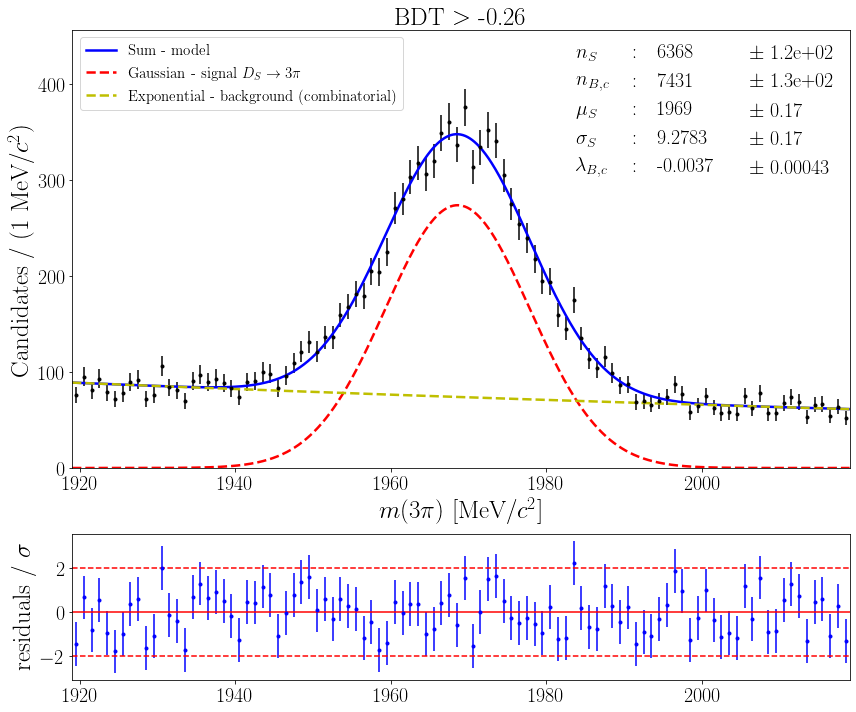

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_common_cutDeltaM_Ds23pi_V8/tau_M_all_common_cutDeltaM_Ds23pi_V8_fit_BDT-0.26.pdf


In [124]:
plot_hist_fit_particle(df_Ds,'tau_M',models = [model_tau,gaussian_ext_tau,exp_ext_tau], 
                       name_models = ["", '$D_S \\to 3\pi$','(combinatorial)'], 
                       colors = ['b','r','y'], cut_BDT=cut_BDT,
                       obs=obs_tau, n_bins = 100,mode_hist = False, name_data=name_data, 
                      params=params_tau,name_params=name_params_tau, fontsize_leg=15.)

In [125]:
corr_B0_M_tau_M = pearsonr(df_Ds['tau_M'], df_Ds['B0_M'])[0]
print(corr_B0_M_tau_M)

0.045957685743507705


In [126]:
save_params(params_tau,name_data + f'_BDT{cut_BDT}', True, {'corr_B0_M_tau_M': corr_B0_M_tau_M})

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/all_common_cutDeltaM_Ds23pi_V8_BDT-0.26_params.json


## Calculate sWeights

We get
- $f_g(m)$, the signal Ds PDF
- $f_e(m)$, the background Ds PDF
Besides, our dataset is given by a list of events, each event is characterised by $m_{3\pi})$

We define the probability of the event $e$ being a $D_s$ by:
$$P\left(e = D_s\right)=\frac{f_g(m_{e, 3\pi})}{\sum_{event\ k}{\left(f_g(m_{k,3\pi})+f_e(m_{k, 3\pi})\right)}}$$

In [127]:
# Probability that the candidate is actually a Ds particle.
mass = df_Ds['tau_M']
probs = pd.DataFrame(dict(sig=gaussian_ext_tau.pdf(mass), bkg=exp_ext_tau.pdf(mass)))
probs = probs.div(probs.sum(axis=1), axis=0) # normalisation.......3

In [128]:
sWeights = splot.compute_sweights(probs)

## Analyse of the sWeigth

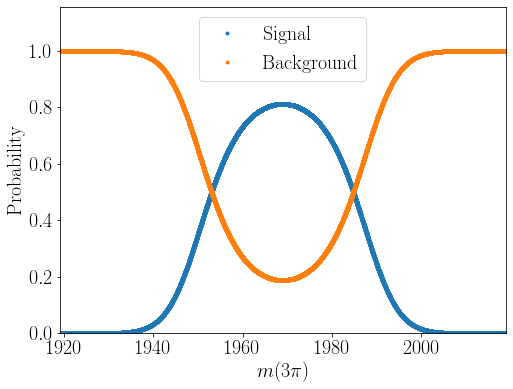

In [129]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(mass, probs.sig,'.', label='Signal')
ax.plot(mass, probs.bkg,'.', label='Background')

plt.xlim(low_tau_M, high_tau_M) 
plt.xlabel('$m(3\pi)$',fontsize=20)
plt.ylabel('Probability',fontsize=20)

fix_plot(ax)


plt.show()
plt.close()

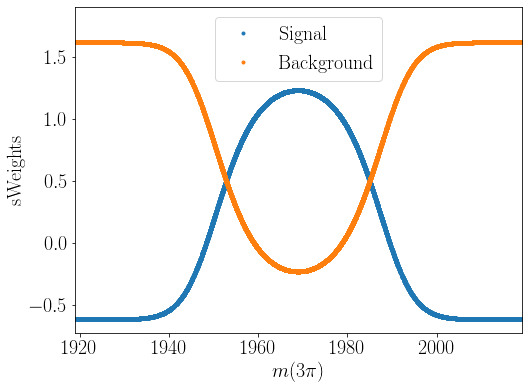

In [130]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(mass, sWeights.sig,'.', label='Signal')
ax.plot(mass, sWeights.bkg,'.', label='Background')

plt.xlim(low_tau_M, high_tau_M) 
fix_plot(ax, ymax=None)

plt.xlabel('$m(3\pi)$',fontsize=20)
plt.ylabel('sWeights',fontsize=20)

ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax*1.1)

plt.show()
plt.close()

## Save weights in a .root file
New column named `sWeight`
The root files are saved in `output/root/common/`

In [131]:
save_dataframe(sWeights, f'common_B0toDstDs_sWeights_BDT{cut_BDT}', 'sWeights', name_folder='common')

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/common/common_B0toDstDs_sWeights_BDT-0.26.root


In [132]:
df_Ds['sWeight'] = sWeights.sig.to_numpy()

/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [133]:
save_dataframe(df_Ds, f'common_B0toDstDs_BDT{cut_BDT}', 'DecayTree', name_folder='common')

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/common/common_B0toDstDs_BDT-0.26.root
